In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [90]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [91]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Загрузка данных и проверка структуры

In [92]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [95]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 2. EDA

In [96]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

 # объединяем
data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

## 2.1 Общий анализ данных

### 2.1.1 Ответы на вопросы

In [97]:
# Количество уникальных значений
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
dtype: int64

## 2.2 Взаимосвязи между признаками

<AxesSubplot: >

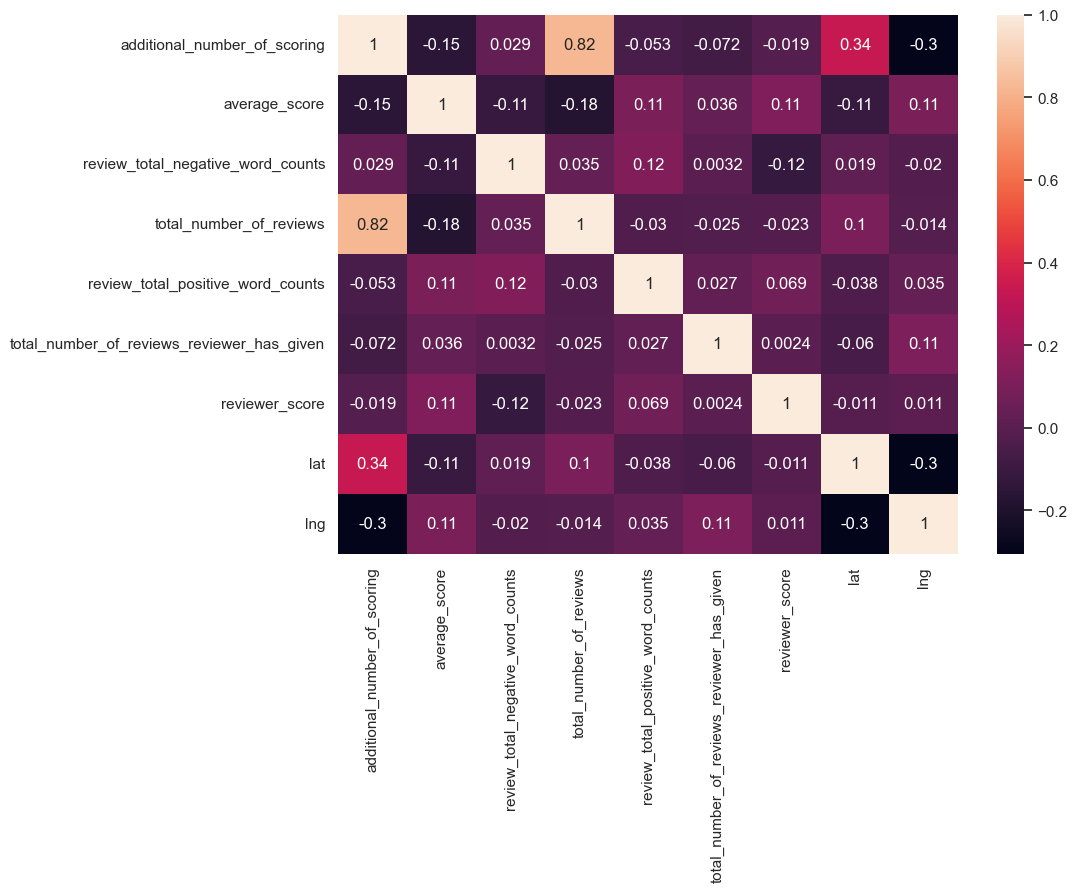

In [98]:
plt.rcParams['figure.figsize'] = (10,7)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Total_number_of_reviews и Additional_scoring сильно коррелируют между собой, один признак можно удалить

Все представленные признаки в текущем виде имеют слабую связь с целевой переменной reviewer_scorе

## 2.3 Создание и преобразование признаков
### 2.3.1 Извлечение информации из текстовых признаков

In [99]:
# Выделение города и страны из адреса

# Примеры: 163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom,
# Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria

def find_city_country(adr):
    adr = adr.replace('United Kingdom', 'UK') # единственная страна, состоящая из двух слов: заменим их на одно
    adr_list = [word for word in adr.split(' ') if word.isalpha()] # выделим в адресе все слова, не включающие цифры
    return (adr_list[len(adr_list)-2], adr_list[len(adr_list)-1]) # вернём кортеж (город, страна)

# Создадим новый признак
data['hotel_city'] = data['hotel_address'].apply(lambda x: find_city_country(x)[0])

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от города')

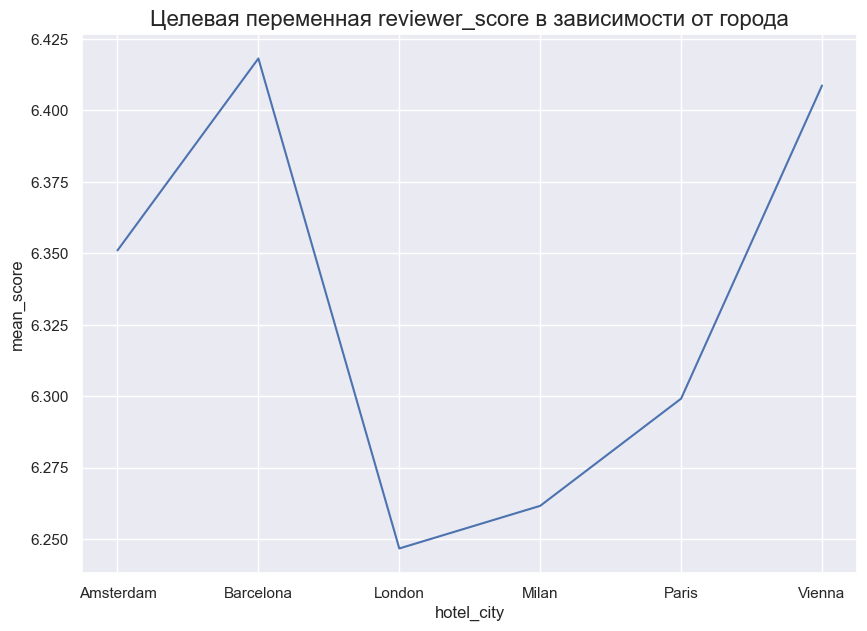

In [100]:
# Посмотрим, есть ли зависимость рейтинга от города
grouped = data.groupby('hotel_city', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='hotel_city', y='mean_score', markers=True)
fig.set_title('Целевая переменная reviewer_score в зависимости от города', fontdict={'fontsize':16})

Изначально была идея выделить страну и город. Оставляю город, так как в представленных данных есть однозначное соответствие между городом и страной.
Информация о городе поможет заполнить пропуски в географических координатах

Средние оценки путешественников немного отличаются в зависимости от города. Если округлить до одного знака после запятой, разница максимум 2 пункта 6.2 - 6.4

Text(0.5, 1.0, 'Распределение отзывов по дням недели')

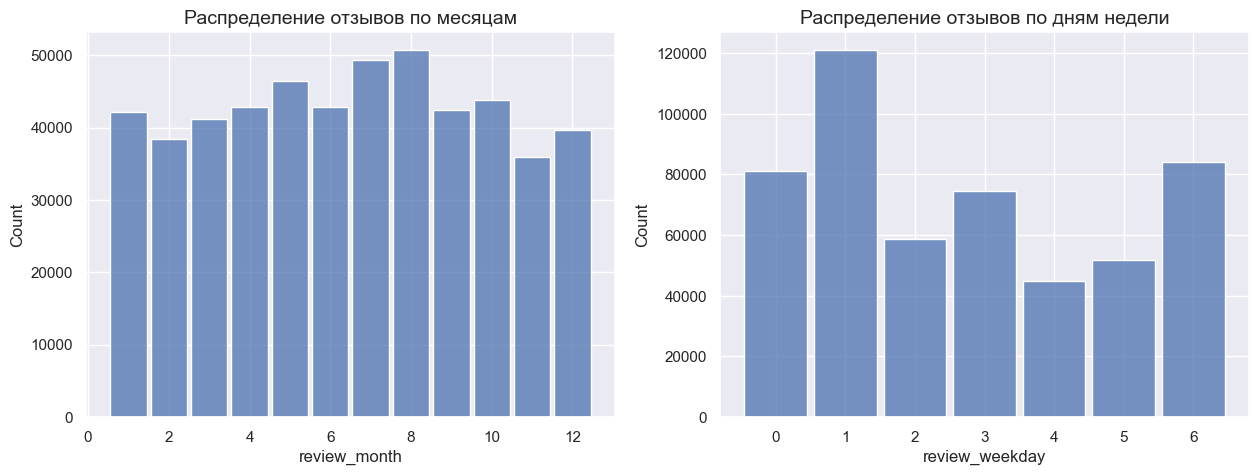

In [101]:
# Работа с датой - выделим признаки месяц и день недели
# Посмотрим на распределение кол-ва отзывов по месяцам и зависимость оценок от дня недели и месяца

data['review_date'] = pd.to_datetime(data['review_date']) # преобразуем формат в дату

data['review_month'] = data['review_date'].dt.month # выделим месяц
data['review_weekday'] = data['review_date'].dt.dayofweek # и день недели
#data['review_month'] = data['review_date'].apply(lambda x: x.split('/')[0]) # даты представлены в формате ММ/ДД/ГГГГ

# Графики распределения отзывов
sns.set_theme()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='review_month', discrete=True, shrink=.9, ax=ax[0])
sns.histplot(data=data, x='review_weekday', discrete=True, shrink=.9, ax=ax[1])
ax[0].set_title('Распределение отзывов по месяцам', fontdict={'size': 14})
ax[1].set_title('Распределение отзывов по дням недели', fontdict={'size': 14})

Пиковые месяцы по количеству отзывов - январь (предположительно по итогам поездок на Новый год и Рождество), май и июль-август (летние отпуска).

Распределение по дням недели: Большое кол-во отзывов в воскресенье, понедельник, вторник (дни 6, 0, 1) - предположительно после поездок, закончившихся в выходные. 

День 3 - возможно добавляются однодневные деловые поездки в начале недели.

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от месяца отзыва')

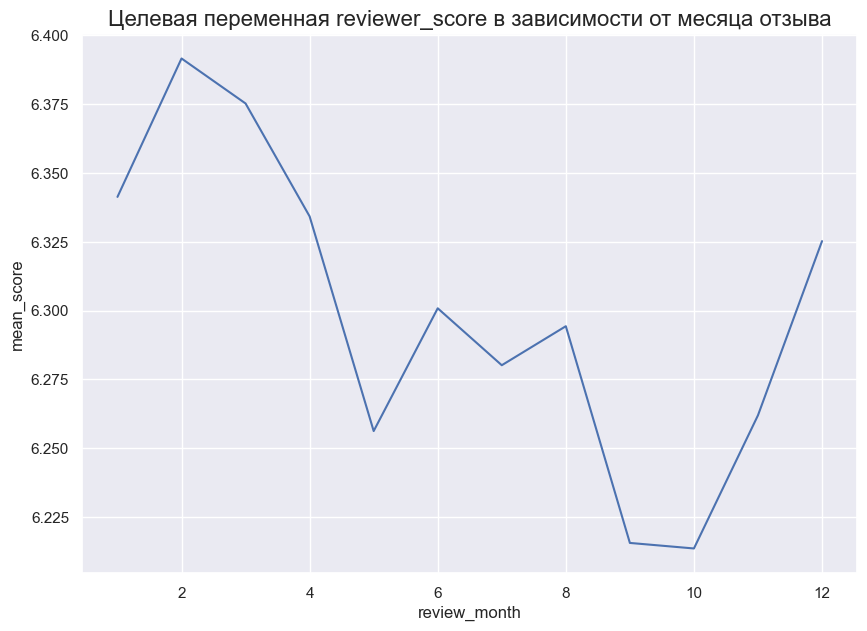

In [102]:
# Зависимость средних оценок от месяца выставления оценки
grouped = data.groupby('review_month', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='review_month', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от месяца отзыва', fontdict={'fontsize':16})

Средние оценки отличаются по временам года: пиковые - зимой, чуть ниже - весной, далее - лето, минимальные - осенью.

Полагаю если объединить месяцы во времена года, график будет иметь более гладкий вид, зависимость будет ближе к линейной.

Но опять же, эти отличия в пределах 0.2: от 6.2 до 6.4

In [103]:
# Признак время года
def season(mth):
    if mth in range (3,6):
        return 'spring'
    elif mth in range (6,9):
        return 'summer'
    elif mth in range (9,12):
        return 'autumn'
    else:
        return 'winter'

data['review_season'] = data['review_month'].apply(season) # новый признак

data['review_season'].value_counts(normalize=True) # распределение отзывов по временам года

summer    0.277052
spring    0.253002
autumn    0.237022
winter    0.232924
Name: review_season, dtype: float64

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от времени года')

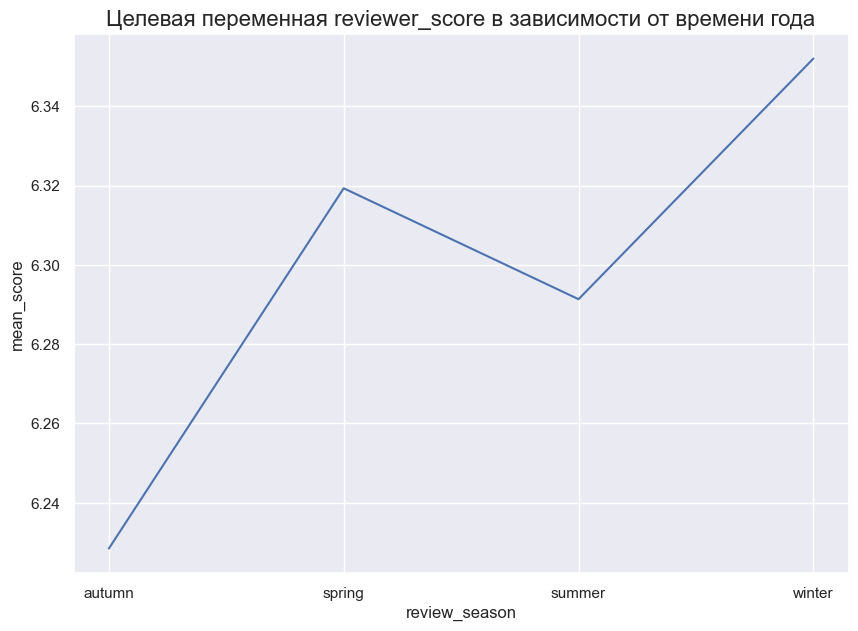

In [104]:
# Зависимость средних оценок от времени года
grouped = data.groupby('review_season', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='review_season', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от времени года', fontdict={'fontsize':16})

Если поменять местами весну и лето (закодировать признаки таким образом), получим рост постоянный рост оценки с изменением времени года.

Возможно придётся кодировать признаки таким образом, чтобы этот момент учесть

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от дня недели')

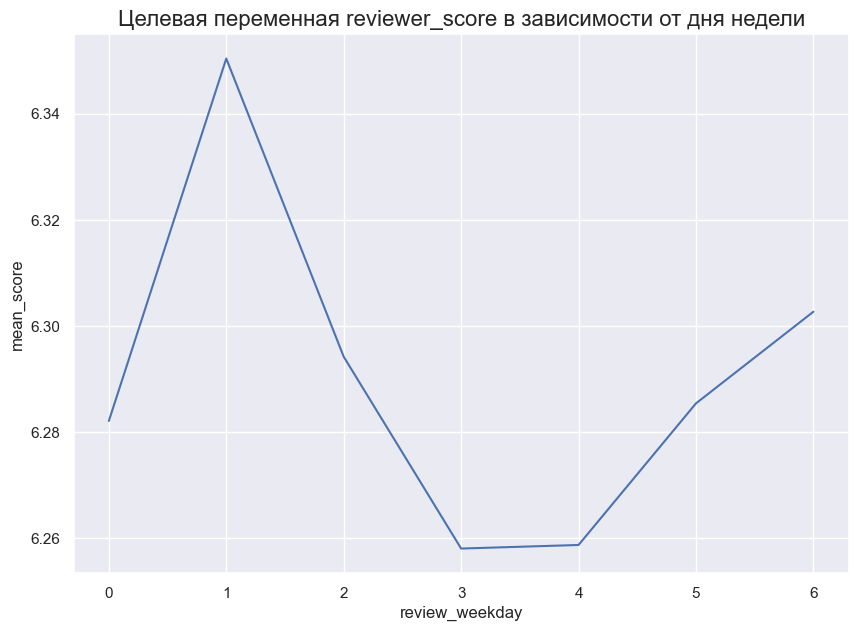

In [105]:
# Зависимость средних оценок от дня недели выставления оценки

grouped = data.groupby('review_weekday', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='review_weekday', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от дня недели', fontdict={'fontsize':16})

Наибольшая средняя оценка наблюдается во вторник (полагаю это связано с количеством людей, отдохнувших на выходных или закончивших свой отпуск в конце недели:)),

как и максимум кол-ва оценок, далее к середине недели достигается минимум, и затем снова начинается рост.

In [106]:
# Национальности путешественников
data['reviewer_nationality'].value_counts(normalize=True).nlargest(15)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
 Saudi Arabia                 0.017356
 Netherlands                  0.017009
 Switzerland                  0.016826
 Germany                      0.015397
 Canada                       0.015306
 France                       0.014147
 Israel                       0.012817
 Italy                        0.011855
 Belgium                      0.011694
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

По количеству отзывов выделяются англичане. 
Можно предложить два варианта группировки по национальности:
(1) англичане и прочие
(2) топ-4 и прочие, так как страны начиная с пятой и ниже, отличаются по кол-ву отзывов от топ-4, но мало отличаются друг от друга. 

In [107]:
# Национальность ревьюера

# Оставим 4 национальности, входящих в топ-15 по кол-ву отзывов (порог >2% от общего числа отзывов)
top_15 = data['reviewer_nationality'].value_counts(normalize=True).nlargest(4).index # список стран топ-15 по кол-ву отзывов

def nat_group(nat):
    if nat in top_15:
        return nat[1:len(nat)-1] # Уберём первый и последний символ - пробелы
    else:
        return 'Other'

# Создадим соответствующий признак
data['reviewer_nat_group'] = data['reviewer_nationality'].apply(lambda x: nat_group(x))

# % отзывов по группам
data['reviewer_nat_group'].value_counts(normalize=True)

United Kingdom              0.475524
Other                       0.384967
United States of America    0.068711
Australia                   0.042048
Ireland                     0.028749
Name: reviewer_nat_group, dtype: float64

Text(0.5, 1.0, 'Целевая переменная reviewer_score в завис. от нации ревьюера')

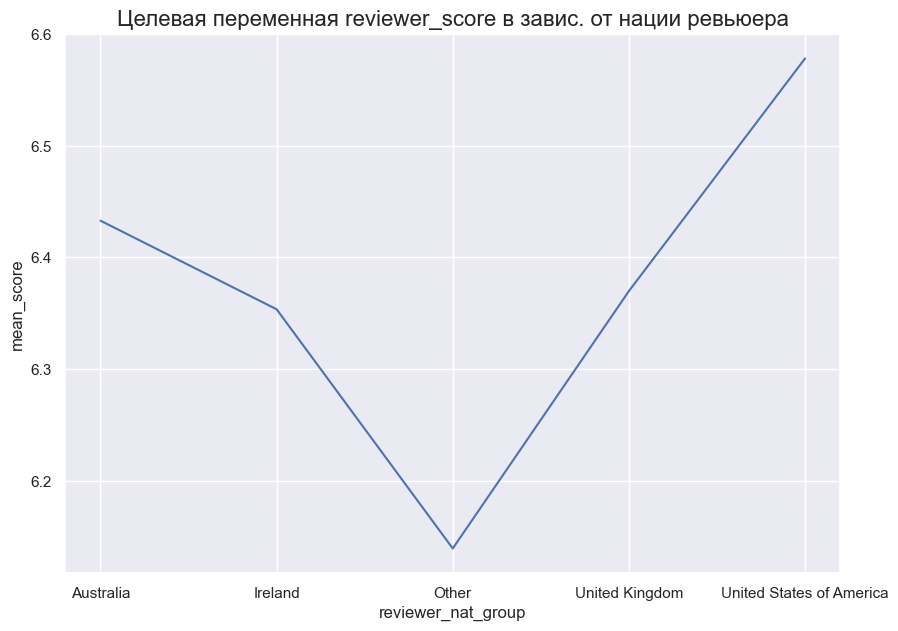

In [108]:
# Посмотрим на оценки в разрезе групп национальностей

grouped = data.groupby('reviewer_nat_group', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='reviewer_nat_group', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в завис. от нации ревьюера', fontdict={'fontsize':16})

Есть отличия в средней оценке в пределах 0.4.

Путешественники из Австралии и США ставят отелям оценки выше, чем остальные.

Полагаю, это связано с тем, что мы рассматриваем города Европы, и возможно путешественники издалека чуть менее требовательны к европейским отелям по сравнению с теми, кто живёт в Европе. Либо Европа дешевле для американцев и австралийцев по сравнению с родными странами, и они получают лучше сервис, чем привыкли дома.

Минимальные оценки в группе Other.

*Есть идея сгруппировать Ирландию и Великобританию, и закодировать страны таким образом, чтобы график был похож на линейную зависимость*

Text(0.5, 1.0, 'Распределение кол-ва дней с момента публикации отзыва')

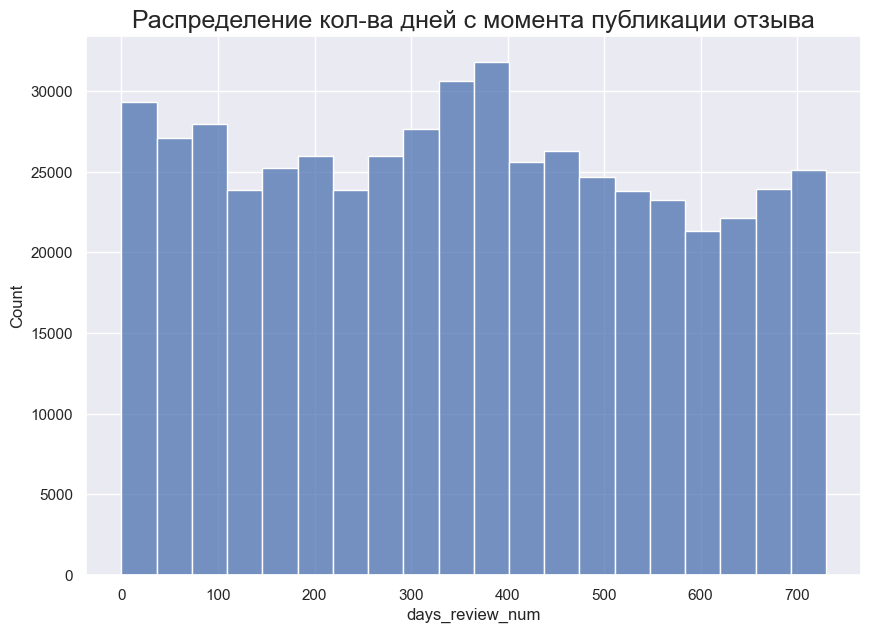

In [109]:
# Количество дней с момента публикации отзыва

def cut_days(days_text):
    days_new = days_text.replace(' day', '')
    # написание кол-ва дней может быть либо days, либо day, необходимо попробовать убрать s после первой замены
    days_new = days_new.replace('s', '')
    return int(days_new)

data['days_review_num'] = data['days_since_review'].apply(lambda x: cut_days(x))

# График распределения
fig = sns.histplot(data=data, x='days_review_num', bins=20)
fig.set_title('Распределение кол-ва дней с момента публикации отзыва', fontdict={'size': 18})

В нашем файле много свежих отзывов (дней с момента публикации чуть больше 0) и отзывов со сроком давности около года (300-400 дней)

Text(0.5, 1.0, 'Средние оценки в зависимости от давности отзыва')

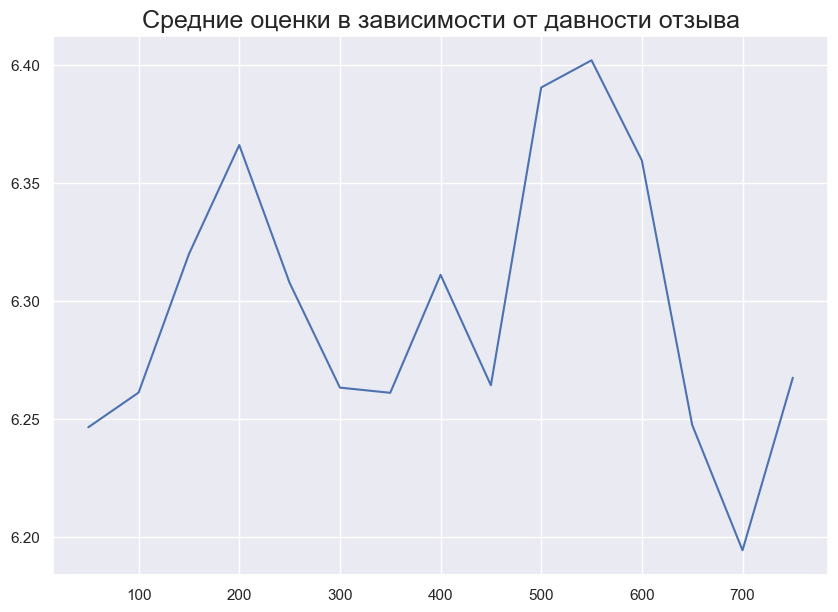

In [110]:
# Проанализируем оценки в зависимости от давности отзыва
days_list=[]
marks = []

for i in range(0, 800, 50):
    days_list.append(i)
    mark = data[(data['days_review_num']<i)&(data['days_review_num']>i-50)]['reviewer_score'].mean()
    marks.append(mark)
    
fig = sns.lineplot(x=days_list, y=marks)
fig.set_title('Средние оценки в зависимости от давности отзыва', fontdict={'size': 18})

Есть небольшие отличия в средних оценках в пределах 0.2, но однозначной зависимости нет, нельзя сказать, что со временем оценки становятся только лучше или только хуже. Скорее всего здесь тоже отражается влияние времён года.

*Не уверена,что стоит использовать этот признак*

**Поработаем с отзывами.** Насколько понимаю, всегда доступны два поля для заполнения отзывов - можно отметить положительные и отрицательные моменты одновременно. Затем выставить оценку. И если отзыв в целом плохой, кол-во слов в "плохой" части гораздо больше, и наоборот.

То есть нас будет интересовать общее кол-во слов в отзыве, оставленном путешественником. И соотношение "плохой" и "хорошей" частей.

Text(0.5, 1.0, 'Распределение % отриц. отзывов')

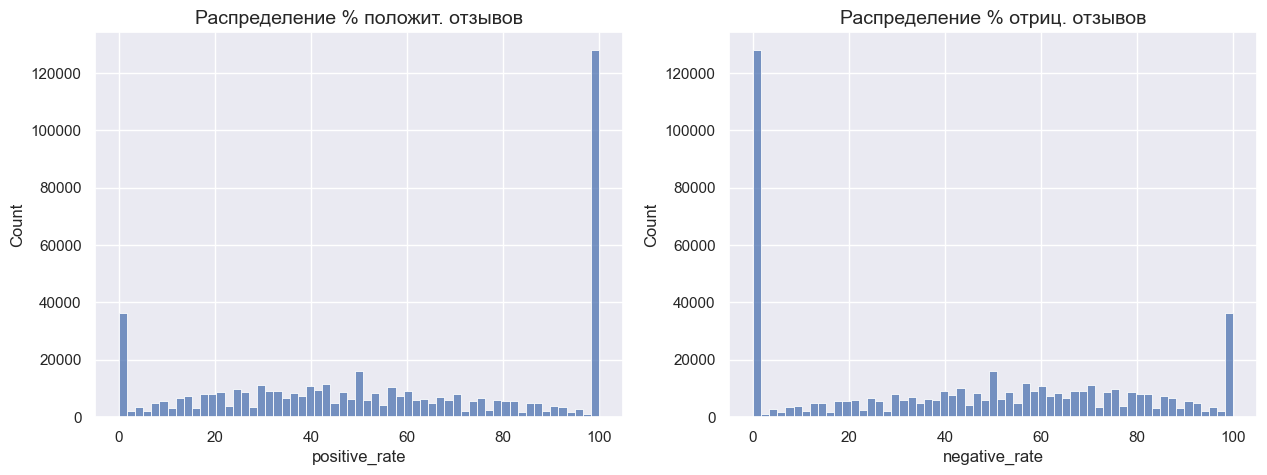

In [111]:
# Всего слов в отзывах каждого пользователя
data['total_words'] = data['review_total_positive_word_counts'] + data['review_total_negative_word_counts']
# Доли положительных и отрицательных частей
data['positive_rate'] = round(data['review_total_positive_word_counts'] / data['total_words'] * 100)
data['negative_rate'] = round(data['review_total_negative_word_counts'] / data['total_words'] * 100)

# Графики распределения отзывов
sns.set_theme()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='positive_rate', ax=ax[0])
sns.histplot(data=data, x='negative_rate', ax=ax[1])
ax[0].set_title('Распределение % положит. отзывов', fontdict={'size': 14})
ax[1].set_title('Распределение % отриц. отзывов', fontdict={'size': 14})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


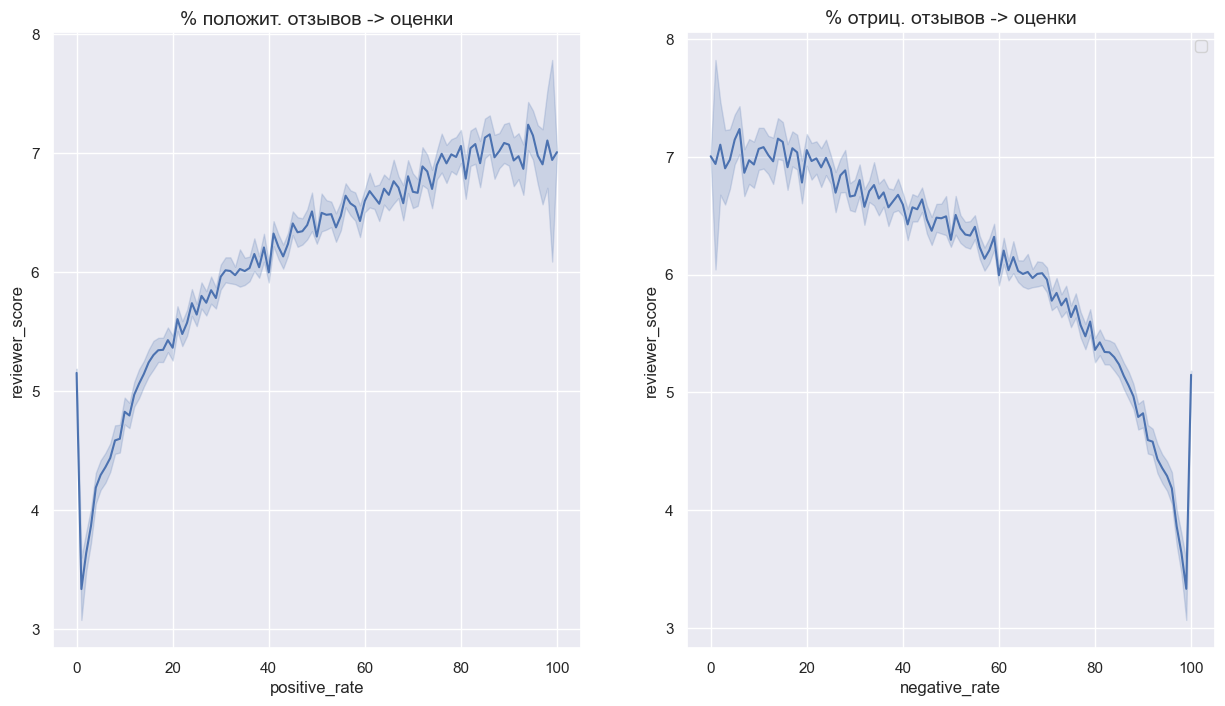

In [112]:
# Завиимость оценок от доли положительных и отрицательных отзывов
fig, (ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax1[0].set_title('% положит. отзывов -> оценки', fontdict={'fontsize': 14})
ax1[1].set_title('% отриц. отзывов -> оценки', fontdict={'fontsize': 14})

sns.lineplot(data=data, x='positive_rate', y='reviewer_score', ax=ax1[0])
sns.lineplot(data=data, x='negative_rate', y='reviewer_score', ax=ax1[1])
plt.legend()

Наблюдается плавный рост оценки с увеличением доли положительных отзывов.

И чем выше доля, тем шире 95% доверительный интервал вокруг среднего значения (область более бледного цвета вокруг тёмной линии на графике)

Начало графика игнорируем, так как у нас в данных есть строки с оценкой, равной нулю - блок тестовых данных

In [113]:
# Пропуски

data[data['negative_rate'].isnull()]['positive_review'].value_counts()

No Positive    127
Name: positive_review, dtype: int64

In [114]:
# Интерпретируем пропуски как 100% негативные отзывы, заполним их соответствующими значениями

values = {'positive_rate': 0.0, 'negative_rate': 100.0}
data = data.fillna(values)

In [115]:
# Разберём положительные отзывы, выясним за что больше всего путешественники хвалят отели
# Возможно получится выделить несколько пунктов и создать соответствующие бинарные признаки

positive_reviews = data['positive_review'].value_counts(normalize=True)
df_rev = pd.DataFrame(data=positive_reviews)
df_rev.to_csv('positive_reviews.csv') # сохраним, чтобы просмотреть все отзывы

# Bed, location, staff, breakfast, clean, room - путешественники часто отмечают это в положительных отзывах
# Создадим бинарные признаки. 1, если этот момент отмечен в отзыве, 0 - не отмечен

data['positive_bed'] = data['positive_review'].apply(lambda x: 1 if 'bed' in x.lower() else 0)
data['positive_location'] = data['positive_review'].apply(lambda x: 1 if 'location' in x.lower() else 0)
data['positive_staff'] = data['positive_review'].apply(lambda x: 1 if 'staff' in x.lower() or 'reception' in x.lower() else 0)
data['positive_breakfast'] = data['positive_review'].apply(lambda x: 1 if 'breakfast' in x.lower() else 0)
data['positive_room'] = data['positive_review'].apply(lambda x: 1 if 'room' in x.lower() else 0)


In [116]:
# Аналогично поработаем с негативными отзывами

negative_reviews = data['negative_review'].value_counts(normalize=True)
df_rev = pd.DataFrame(data=negative_reviews)
df_rev.to_csv('negative_reviews.csv') # сохраним, чтобы просмотреть все отзывы

# Nois, bed, breakfast, bath or shower, clean, dirt, internet or wi fi or wifi, room, staff or reception, charge or expensive or price or cost, tired or old, 
# Найдём наиболее часто встречающиеся слова в тексте и создадим соответствующие признаки:
# 1, если путешественник жаловался на эту вещь, 0 - если нет

data['negative_meal'] = data['negative_review'].apply(lambda x: 1 if 'breakfast' in x.lower()
                                                      or 'meal' in x.lower() or 'dinner' in x.lower() else 0)
data['negative_bed'] = data['negative_review'].apply(lambda x: 1 if 'bed' in x.lower() else 0)
data['negative_bath'] = data['negative_review'].apply(lambda x: 1 if 'bath' in x.lower() or 'shower' in x.lower() else 0)
data['negative_wifi'] = data['negative_review'].apply(lambda x: 1 if 'internet' in x.lower() or 'wifi' in x.lower()
                                                      or 'wi fi' in x.lower() or 'wi-fi' in x.lower() else 0)
data['negative_staff'] = data['negative_review'].apply(lambda x: 1 if 'staff' in x.lower() or 'reception' in x.lower() else 0)
data['negative_price'] = data['negative_review'].apply(lambda x: 1 if 'charge' in x.lower() or 'price' in x.lower()
                                                       or 'expensive' in x.lower() or 'cost' in x.lower()
                                                       or 'euro' in x.lower() or 'pound' in x.lower()
                                                       or 'pricey' in x.lower() or 'pricy' in x.lower() else 0)
data['negative_old'] = data['negative_review'].apply(lambda x: 1 if 'old' in x.lower() or 'tired' in x.lower()
                                                     or 'renovation' in x.lower() else 0)
data['negative_location'] = data['negative_review'].apply(lambda x: 1 if 'far away' in x.lower() or 'bit of walk' in x.lower()
                                                          or 'walk from' in x.lower() or 'out of the way' in x.lower()
                                                          or 'far from' in x.lower() else 0)
data['negative_clean'] = data['negative_review'].apply(lambda x: 1 if 'clean' in x.lower() or 'dirt' in x.lower() else 0)


In [117]:
# Проанализируем теги

tags = data['tags'].value_counts(normalize=True)
df_tags = pd.DataFrame(data=tags)
df_tags.to_csv('tags.csv') # сохраним, чтобы просмотреть все теги

# Цель путешествия
def trip_purp(tags_text): 
    if 'Business' in tags_text:
        return 'Business'
    elif 'Leisure' in tags_text:
        return 'Leisure'
    else:
        return 'Unknown'
    
# Состав путешественников
def who_travels(tags_text):
    if 'Solo' in tags_text:
        return 'Solo'
    elif 'Couple' in tags_text:
        return 'Couple'
    elif 'Family' in tags_text:
        return 'Family'
    elif 'friends' in tags_text:
        return 'Friends'
    elif 'pet' in tags_text:
        return 'With a pet'
    elif 'Group' in tags_text:
        return 'Group'
    else:
        return 'Other'
    
# Длительность путешествия
def trip_duration(tags_text):
    # Индекс нужного нам тега не всегда одинаков, так как некоторые теги могут быть пропущены, будем искать
    days = tags_text.find('Stayed')
    if days > 0:
        return int(tags_text[days+6:days+9]) # если нашли такой тег, возвращаем следом идущее кол-во дней, максимум двузначное
    return -1 # если не нашли нужный тег

# Информацию о номере, в котором было размещение, пока не используем


# Признаки
data['trip_purpose'] = data['tags'].apply(trip_purp) # цель путешествия
data['who_travels'] = data['tags'].apply(who_travels) # состав путешественников
data['trip_duration'] = data['tags'].apply(trip_duration) # длительность путешествия в днях

Text(0.5, 1.0, 'Распределение кол-ва дней пребывания в отеле')

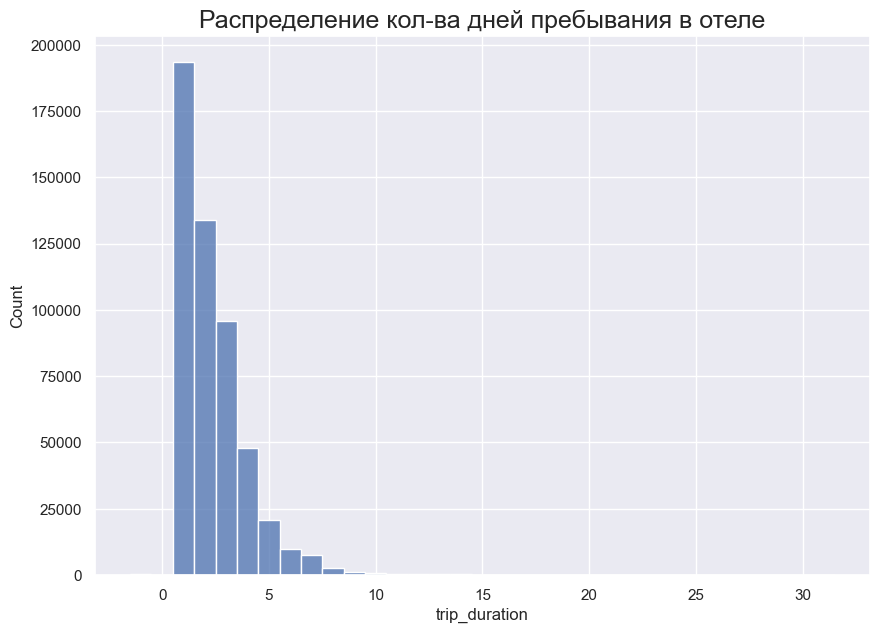

In [118]:
# График распределения
fig = sns.histplot(data=data, x='trip_duration', discrete=True)
fig.set_title('Распределение кол-ва дней пребывания в отеле', fontdict={'size': 18})

Большинство путешественников останавливаются в отеле на один день. Свыше 5 дней - очень редко

Text(0.5, 1.0, 'Целевая переменная reviewer_score в завис. от длительности поездки')

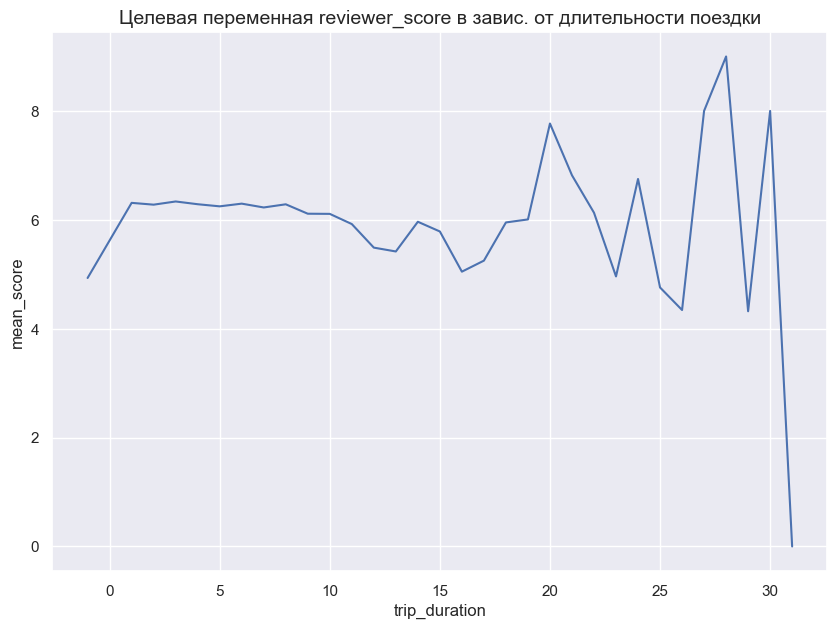

In [119]:
# Зависимость оценки от продолжительности путешествия

grouped = data.groupby('trip_duration', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='trip_duration', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в завис. от длительности поездки', fontdict={'fontsize':14})

Продолжительность поездки -1 день - тот случай, когда не нашли нужного тега в данных.

Видно, что с увеличением продолжительности поездки растёт разброс средних оценок, и приэтом график распределения показывает, что кол-во путешественников при этом снижается (видимо это и является причиной растущего разброса).

Изменим признак, создадим две группы - продолжительность поездки до 15 (20?) дней и свыше 15 дней. Значение -1 попадёт в первый интервал: это выглядит логичным, если его заменить модальным либо средним значением, получим цифру менее 15

In [120]:
# преобразуем признак в бинарный
data['trip_duration_bin'] = data['trip_duration'].apply(lambda x: 1 if x<=15 else 0)

data.groupby('trip_duration_bin').agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

,count,mean_score
trip_duration_bin,,
0,278,5.967266
1,515460,6.297850


In [121]:
# Создадим список из Топ-20 отелей
top_20_hotels = list(data['hotel_name'].value_counts().nlargest(20).index)

# Заменим название отелей, не вошедших в Топ-20 на 'Other'
data['hotel_name'] = data['hotel_name'].apply(lambda name: name if name in top_20_hotels else 'Other')
display(data['hotel_name'].value_counts())

Other                                                460873
Britannia International Hotel Canary Wharf             4789
Strand Palace Hotel                                    4256
Park Plaza Westminster Bridge London                   4169
Copthorne Tara Hotel London Kensington                 3578
DoubleTree by Hilton Hotel London Tower of London      3212
Grand Royale London Hyde Park                          2958
Holiday Inn London Kensington                          2768
Hilton London Metropole                                2628
Millennium Gloucester Hotel London                     2565
Intercontinental London The O2                         2551
Park Grand Paddington Court                            2288
Hilton London Wembley                                  2227
Park Plaza County Hall London                          2223
Blakemore Hyde Park                                    2178
Park Plaza London Riverbank                            2167
M by Montcalm Shoreditch London Tech Cit

В процессе анализа названий выяснилось, что названия отелей содержат ошибки, возможно были проблемы со шрифтами. Например H tel вместо Hotel, Le M ridien вместо Le Meridien.

In [122]:
# Спарсить инофрмацию о звёздности отеля и возможно стоимости за ночь
# Добавить к данным

### 2.3.3 Заполнение пропусков

Text(0.5, 1.0, 'Широта')

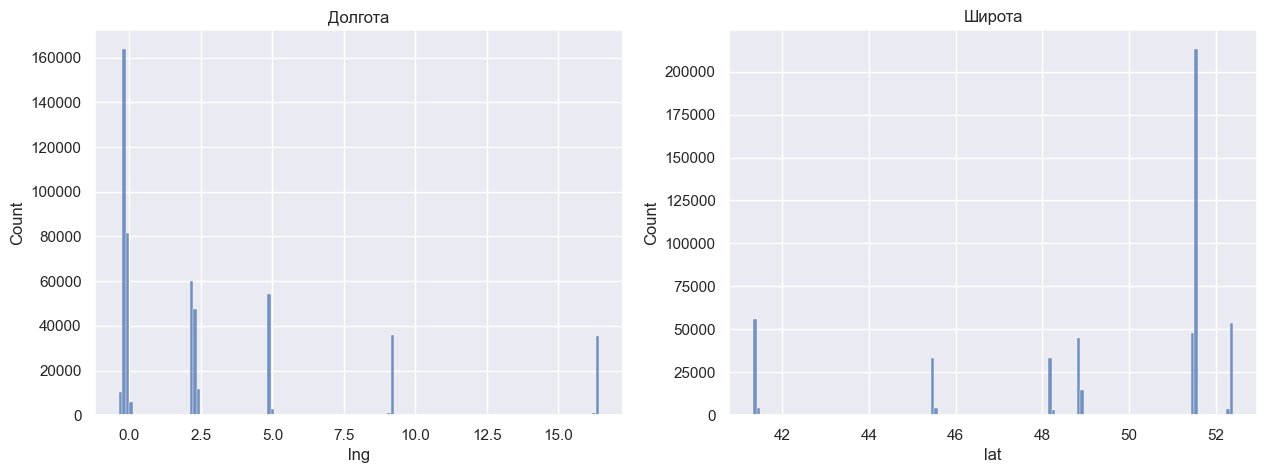

In [123]:
# Признаки с пропусками - долгота и широта - по идее можно заполнить на основании созданного признака hotel_city

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(x='lng', data=data, ax=ax[0])
ax[0].set_title('Долгота')
sns.histplot(x='lat', data=data, ax=ax[1])
ax[1].set_title('Широта')

In [124]:
# Оценим, как пропуски распределяются по городам

data[data['lat'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count'))

,hotel_city,qty
0,Barcelona,207
1,Paris,382
2,Vienna,2679


In [125]:
# Рассчитаем средние значения широты и долготы для каждого города
data.groupby('hotel_city', as_index=False).agg(mean_lat=('lat', 'mean'), mean_lng=('lng', 'mean'))

,hotel_city,mean_lat,mean_lng
0,Amsterdam,52.362206,4.885409
1,Barcelona,41.389079,2.169147
2,London,51.510739,-0.138960
3,Milan,45.479617,9.191835
4,Paris,48.863715,2.326780
5,Vienna,48.203362,16.367234


In [126]:
# Заполним пропуски средними значениями для каждого города
data.loc[(data['hotel_city']=='Barcelona') & (data['lat'].isnull()), 'lat'] = 41.389079
data.loc[(data['hotel_city']=='Barcelona') & (data['lng'].isnull()), 'lng'] = 2.169147

data.loc[(data['hotel_city']=='Paris') & (data['lat'].isnull()), 'lat'] = 48.863715
data.loc[(data['hotel_city']=='Paris') & (data['lng'].isnull()), 'lng'] = 2.326780

data.loc[(data['hotel_city']=='Vienna') & (data['lat'].isnull()), 'lat'] = 48.203362
data.loc[(data['hotel_city']=='Vienna') & (data['lng'].isnull()), 'lng'] = 16.367234

С другой стороны, такое однозначное соответствие между городами и координатами наверняка говорит о дублировании информации.

Полагаю что придётся какие-то признаки удалить

### 2.3.4 Кодирование категориальных признаков

In [127]:
data.info() # проверим структуру

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [128]:
# Кодирование OneHotEncoding для признаков, содержащих менее 10 уникальных значений
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['hotel_city']) # город - 6 значений
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['trip_purpose']) # цель путешествия - 3 значения
type_bin = encoder.fit_transform(data['trip_purpose'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['who_travels']) # состав путешественников - 6 значений
type_bin = encoder.fit_transform(data['who_travels'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['reviewer_nat_group']) # группы национальностей - 6 значений
type_bin = encoder.fit_transform(data['reviewer_nat_group'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['review_weekday']) # дни недели - 7 значений
type_bin = encoder.fit_transform(data['review_weekday'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['review_season']) # времена года - 4 значения
type_bin = encoder.fit_transform(data['review_season'])
data = pd.concat([data, type_bin], axis=1)


In [129]:
# Двоичное кодирование для признаков, содержащих более 10 значений
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

# Удаление текстовых и закодированных категориальных признаков
cols_to_del = ['additional_number_of_scoring', # корреляция с другим признаком
                'hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', # текстовые
                'negative_review', 'positive_review', 'tags', 'days_since_review',
                'hotel_city', 'review_weekday', 'review_month', 'review_season', # категориальные
                'reviewer_nat_group', 'trip_purpose', 'who_travels', 'trip_duration'
                ]

data = data.drop(cols_to_del, axis=1)

### 2.3.5 Преобразование числовых признаков

Text(0.5, 1.0, 'Целевая переменная reviewer_score в завис. от кол-ва прошлых отзывов')

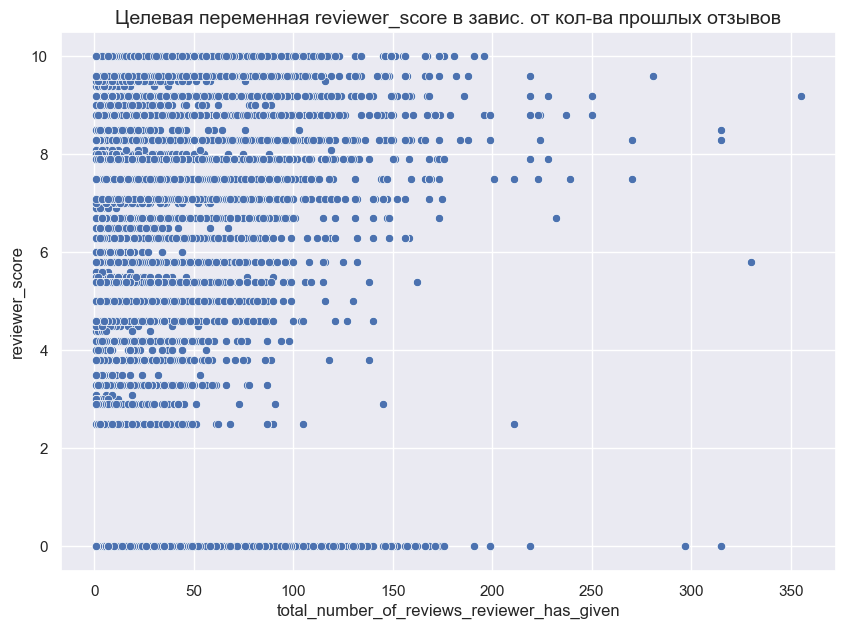

In [131]:
# Зависимость оценки от продолжительности путешествия

fig = sns.scatterplot(data=data, x='total_number_of_reviews_reviewer_has_given', y='reviewer_score')
fig.set_title('Целевая переменная reviewer_score в завис. от кол-ва прошлых отзывов', fontdict={'fontsize':14})

**Идея: если у отеля много отзывов, он популярен и наверняка имеет высокие оценки.**

Видим,отели с низкими прошлыми оценками до 4 чаще всего имеют кол-во прошлых отзывов до 50, с оценками 4-7 - до 100,

а те отели, у которых самое большое кол-во прошлых отзывов, имеют высокие оценки 8-10.

Есть отдельные точки, которые можно определить как выбросы.

**Возможно имеет смысл превратить признак в категориальный, сгруппировать кол-во прошлых отзывов в интервалах до 50, 50-100, 100-150 и свыше 150.**

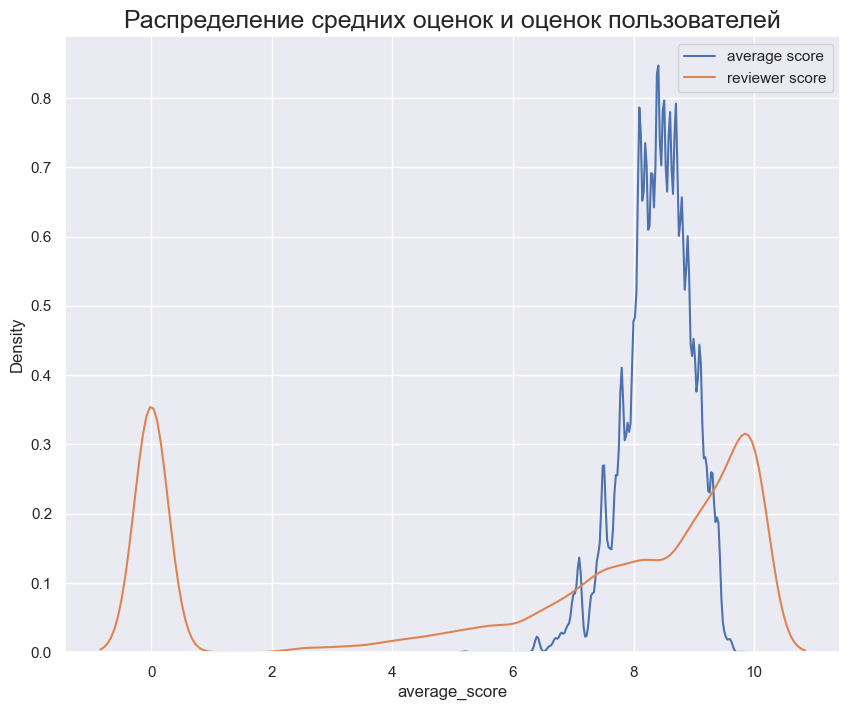

In [132]:
# Параметры графиков
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение средних оценок и оценок пользователей', fontdict={'fontsize': 18})

# reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
#average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
sns.kdeplot(data['average_score'], ax=ax1, label ='average score')
sns.kdeplot(data['reviewer_score'], ax=ax1, label ='reviewer score')
plt.legend()

Text(0.5, 1.0, 'Целевая переменная reviewer_score в завис. от текущей средней оценки')

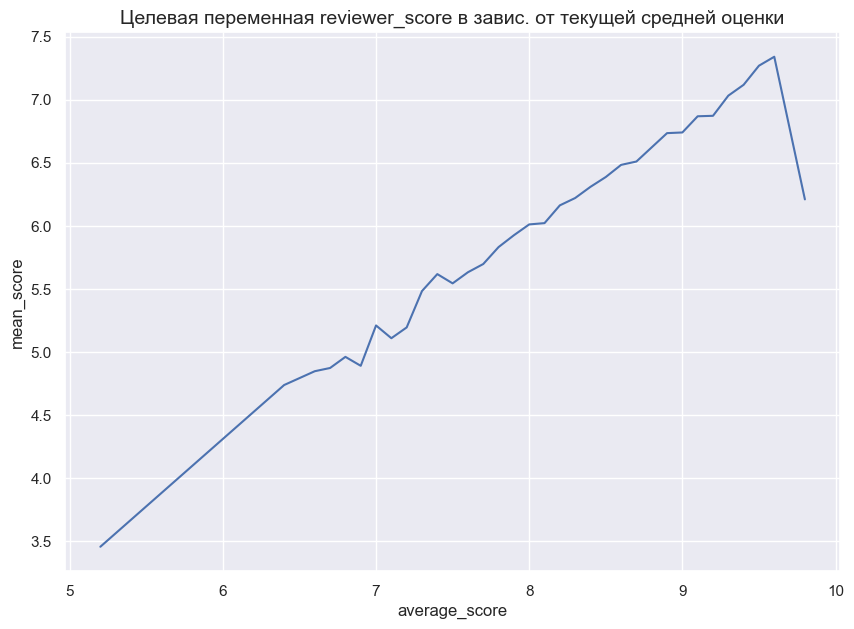

In [133]:
# Зависимость оценки от текущей средней оценки отеля

# Сгруппируем данные по средним оценкам. Это возможно, таких значений ограниченное число
grouped = data.groupby('average_score', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='average_score', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в завис. от текущей средней оценки', fontdict={'fontsize':14})

График показывает **практически прямую зависимость** оценки пользователя от текущей средней оценки для данного отеля.

Тенденция нарушается для отелей с очень высокими средними оценками - выше 9.6.
Пользователи из нашего датасета оценили такие отели хуже средних оценок,

**и зависимость на интервале примерно 9.6 - 10 обратная**

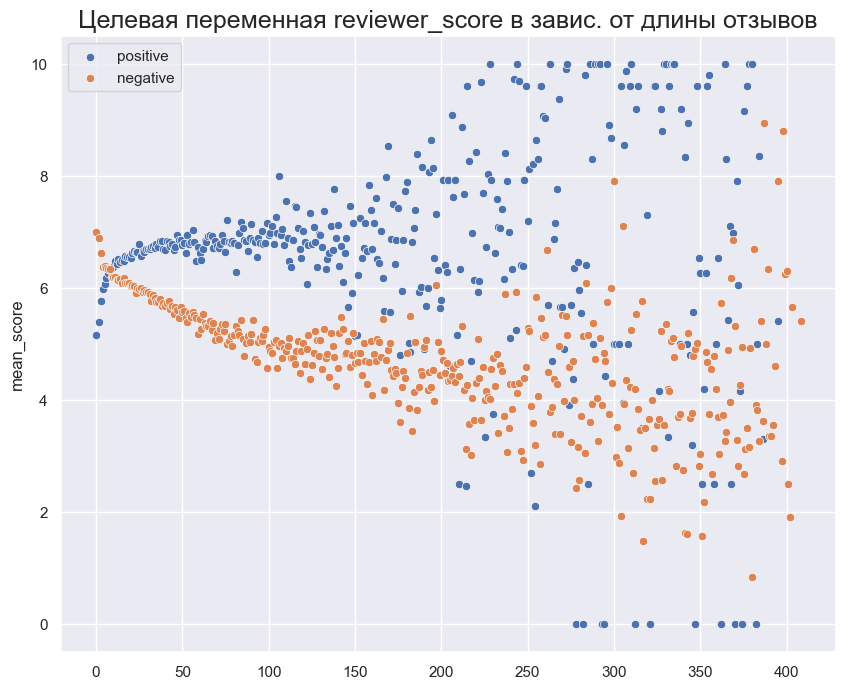

In [134]:
# Зависимость оценки от количества слов в отзывах

# Сгруппируем данные по кол-ву слов в отзывах
grouped_pos = data.groupby('review_total_positive_word_counts', as_index=False).agg(count=('reviewer_score', 'count'),
                                                                                    mean_score=('reviewer_score', 'mean'))
grouped_neg = data.groupby('review_total_negative_word_counts', as_index=False).agg(count=('reviewer_score', 'count'),
                                                                                    mean_score=('reviewer_score', 'mean'))

# Выведем зависимости на одном графике
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Целевая переменная reviewer_score в завис. от длины отзывов', fontdict={'fontsize': 18})

sns.scatterplot(data=grouped_pos, x='review_total_positive_word_counts', y='mean_score', ax=ax1)
sns.scatterplot(data=grouped_neg, x='review_total_negative_word_counts', y='mean_score', ax=ax1)
ax1.set_xlabel('')
plt.legend(['positive', 'negative'])


В данном случае не видно какой-либо зависимости, видно что с увеличением кол-ва отзывов растёт дисперсия средних оценок пользователей

Text(0.5, 1.0, 'Целевая переменная reviewer_score в завис. от кол-ва прошлых отзывов путешественника')

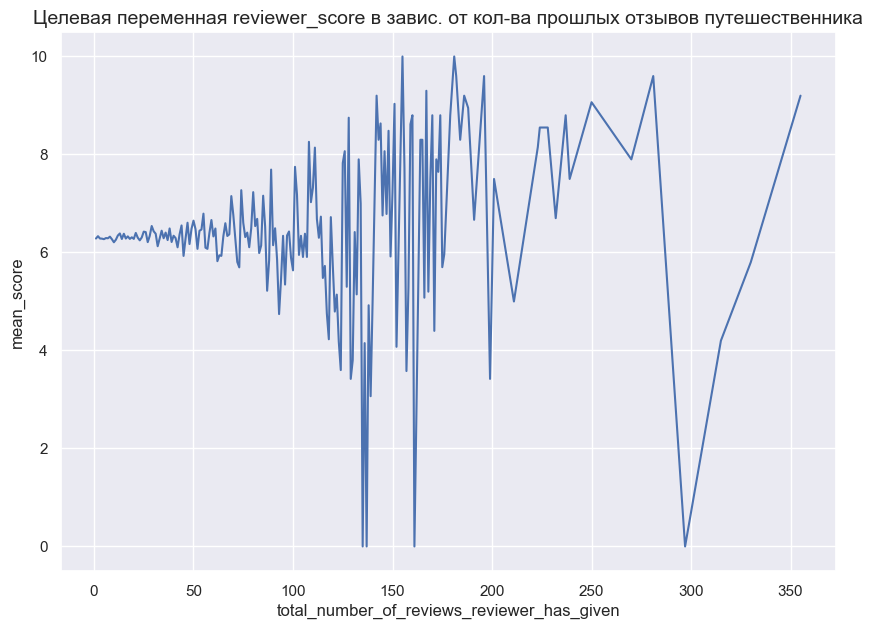

In [135]:
# Зависимость оценки от кол-ва отзывов, оставленных путешественником в прошлом

# Сгруппируем данные
grouped = data.groupby('total_number_of_reviews_reviewer_has_given', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

# График
fig = sns.lineplot(data=grouped, x='total_number_of_reviews_reviewer_has_given', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в завис. от кол-ва прошлых отзывов путешественника', fontdict={'fontsize':14})

Аналогично предыдущему признаку, никакой зависимости, есть только рост дисперсии оценок с ростом кол-ва прошлых отзывов, оставленных человеком.

Также после определённого значения (200 отзывов?) кол-во людей видимо резко уменьшается, и получается ещё более сильный разброс оценок

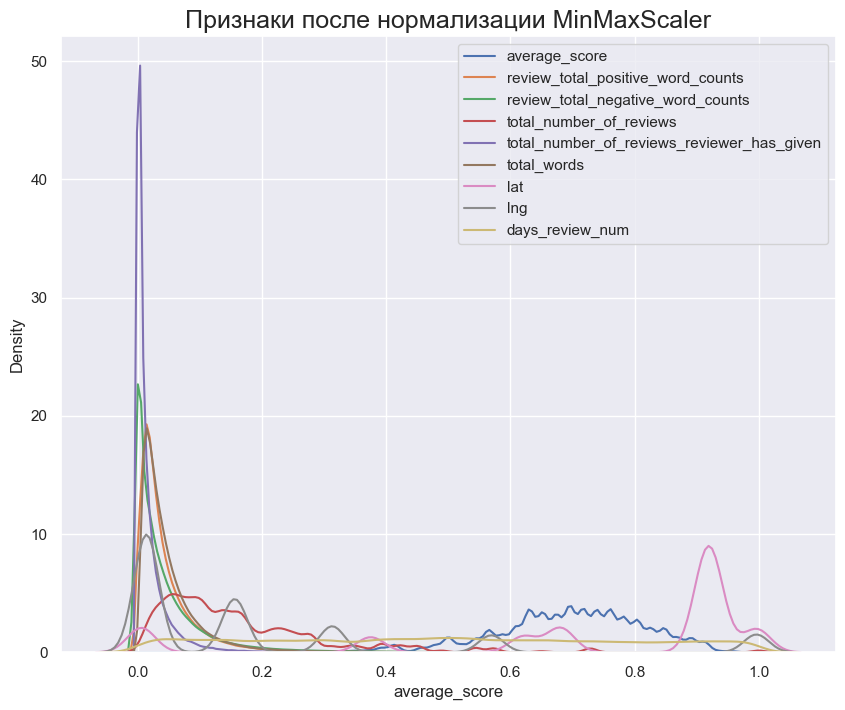

In [136]:
# Нормализация числовых признаков
from sklearn import preprocessing

cols_num = ['average_score', 'review_total_positive_word_counts', 'review_total_negative_word_counts',
            'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'total_words',
            'lat', 'lng', 'days_review_num'] # числовые признаки для нормализации

mm_scaler = preprocessing.MinMaxScaler()
data_num = data[cols_num].copy() # скопируем эти данные

data_num_mm = mm_scaler.fit_transform(data_num)
data_num_mm = pd.DataFrame(data_num_mm, columns=cols_num)


# Визуализация
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Признаки после нормализации MinMaxScaler', fontdict={'fontsize': 18})

for col in cols_num:
    sns.kdeplot(data_num_mm[col], ax=ax1)

plt.legend(cols_num)

## 2.4 Анализ мультиколлинеарности и отбор признаков

<AxesSubplot: >

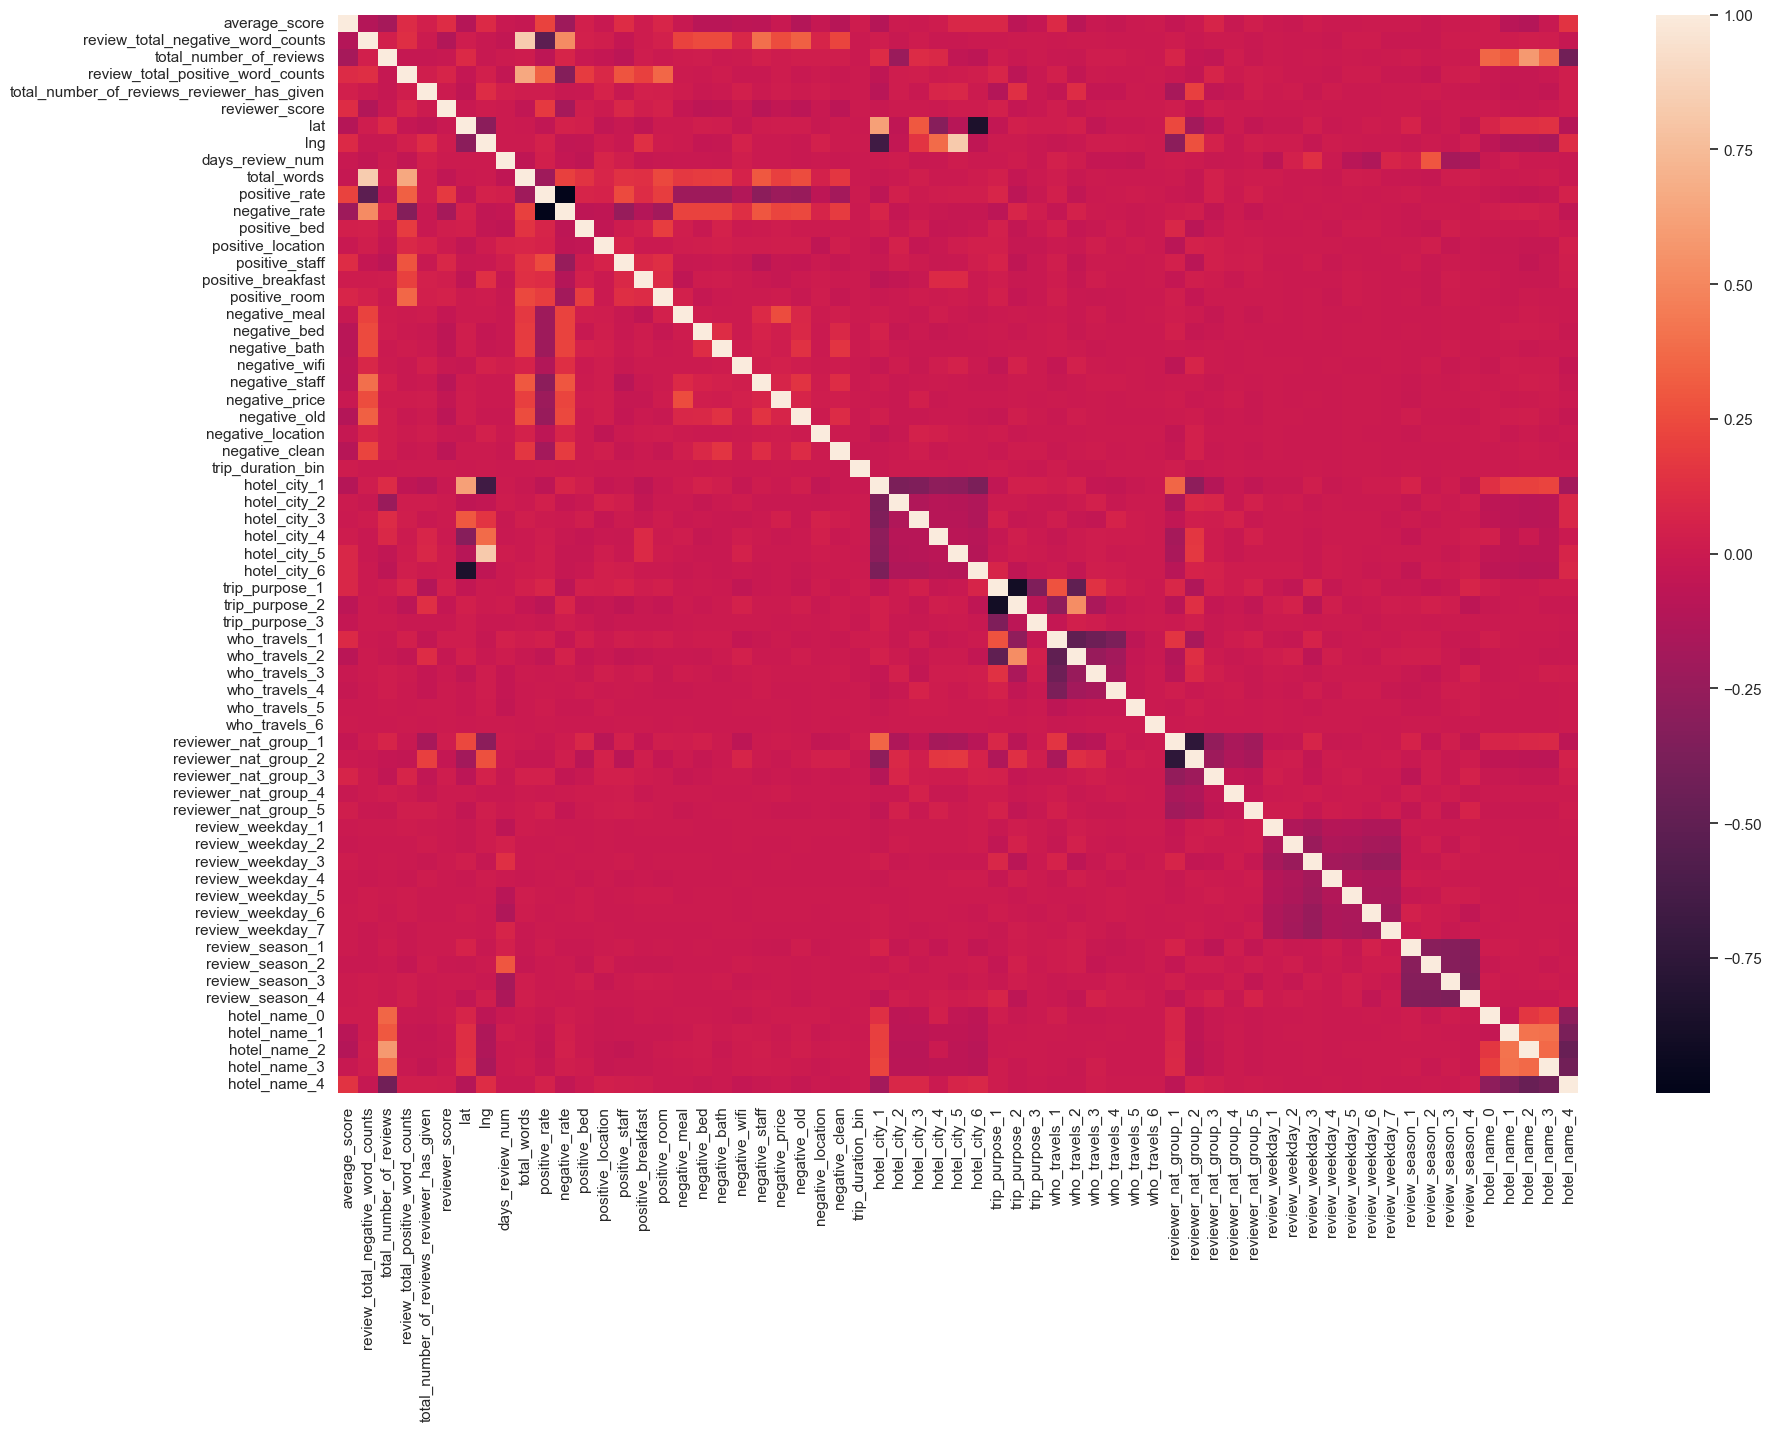

In [137]:
plt.rcParams['figure.figsize'] = (20,14)
sns.heatmap(data.drop(['sample'], axis=1).corr())

In [138]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   days_review_num                             515738 non-null  int64  
 

In [140]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
           'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'total_number_of_reviews', 'days_review_num', 'total_words',
            'positive_rate', 'negative_rate'
           ]

# категориальные признаки
# множество всех признаков - мн-во непрерывных - флаг 'sample' для разделения выборок
cat_cols = list(set(data.columns) - set(num_cols) - {'reviewer_score', 'sample'})

# преобразуем значения категориальных признаков в целые числа
for col in cat_cols:
    X[col] = X[col].astype(int)

<AxesSubplot: >

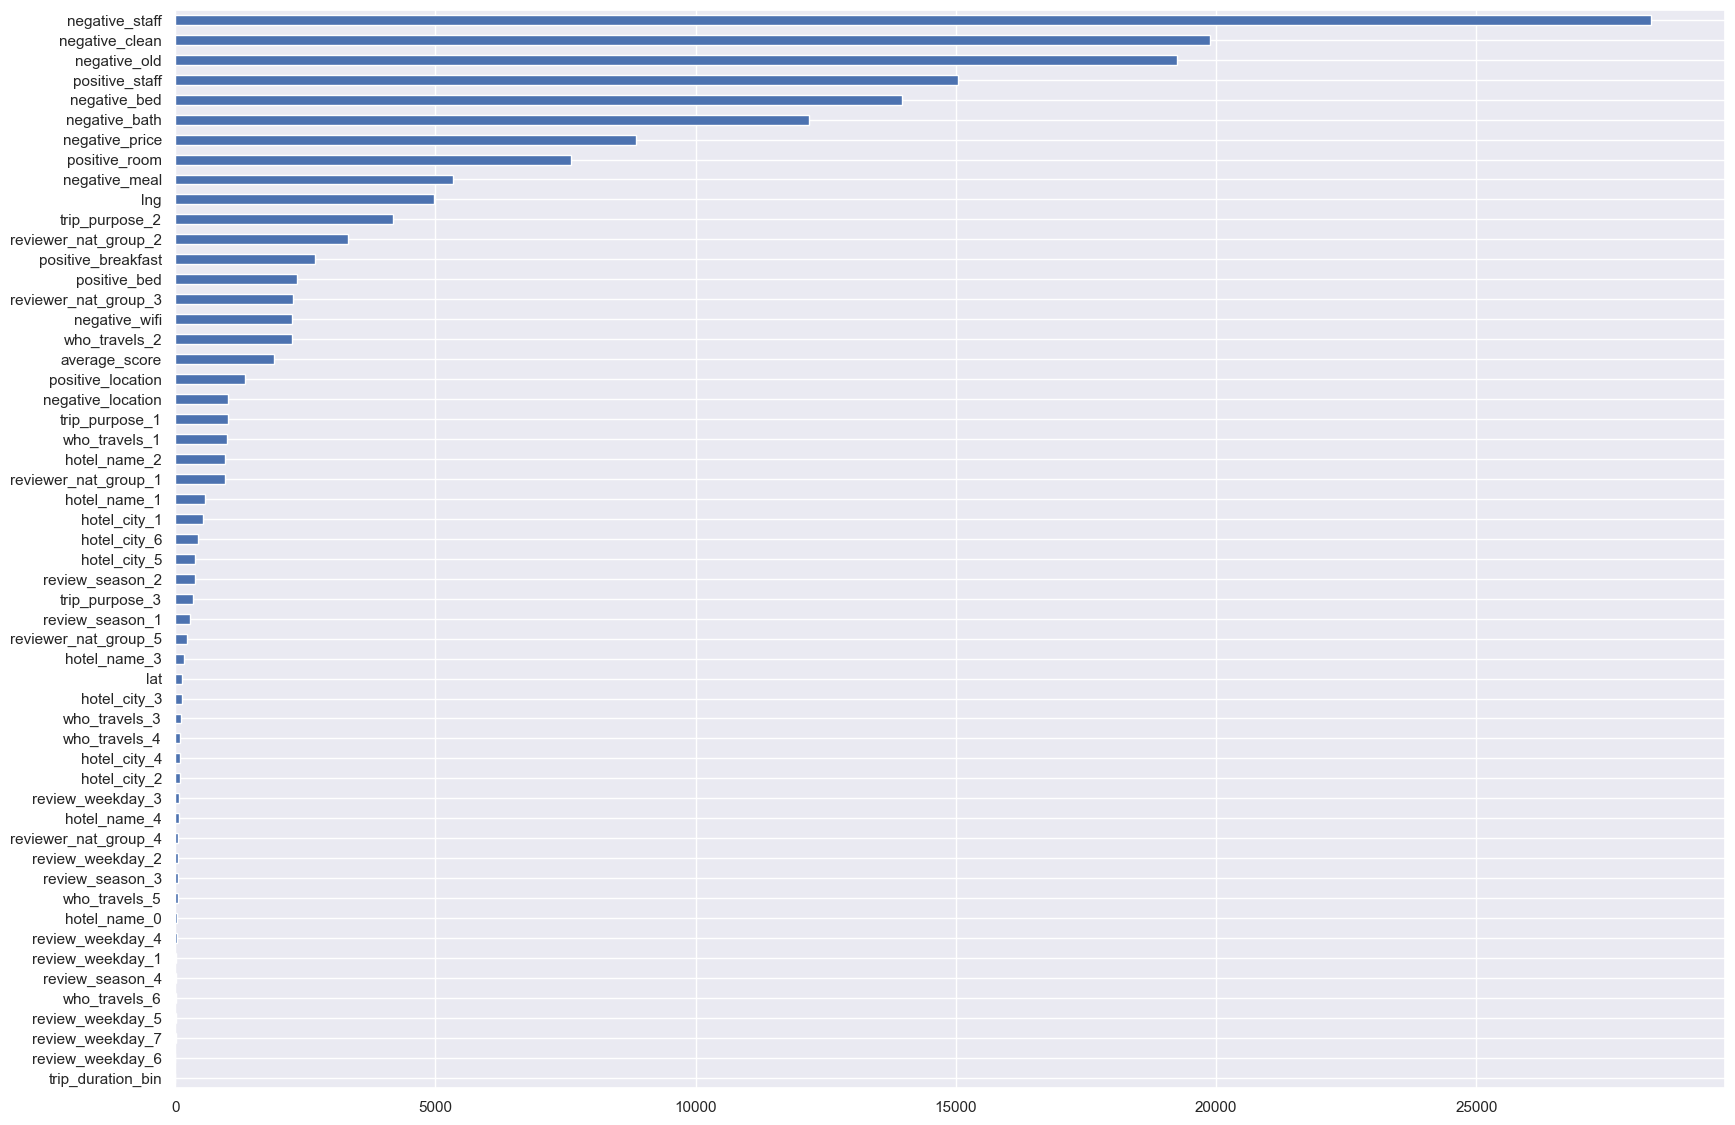

In [141]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#['trip_purpose_2', 'reviewer_nat_group_2', 'positive_breakfast', 'positive_bed', 'reviewer_nat_group_3', 'negative_wifi', 'who_travels_3', 'average_score']


<AxesSubplot: >

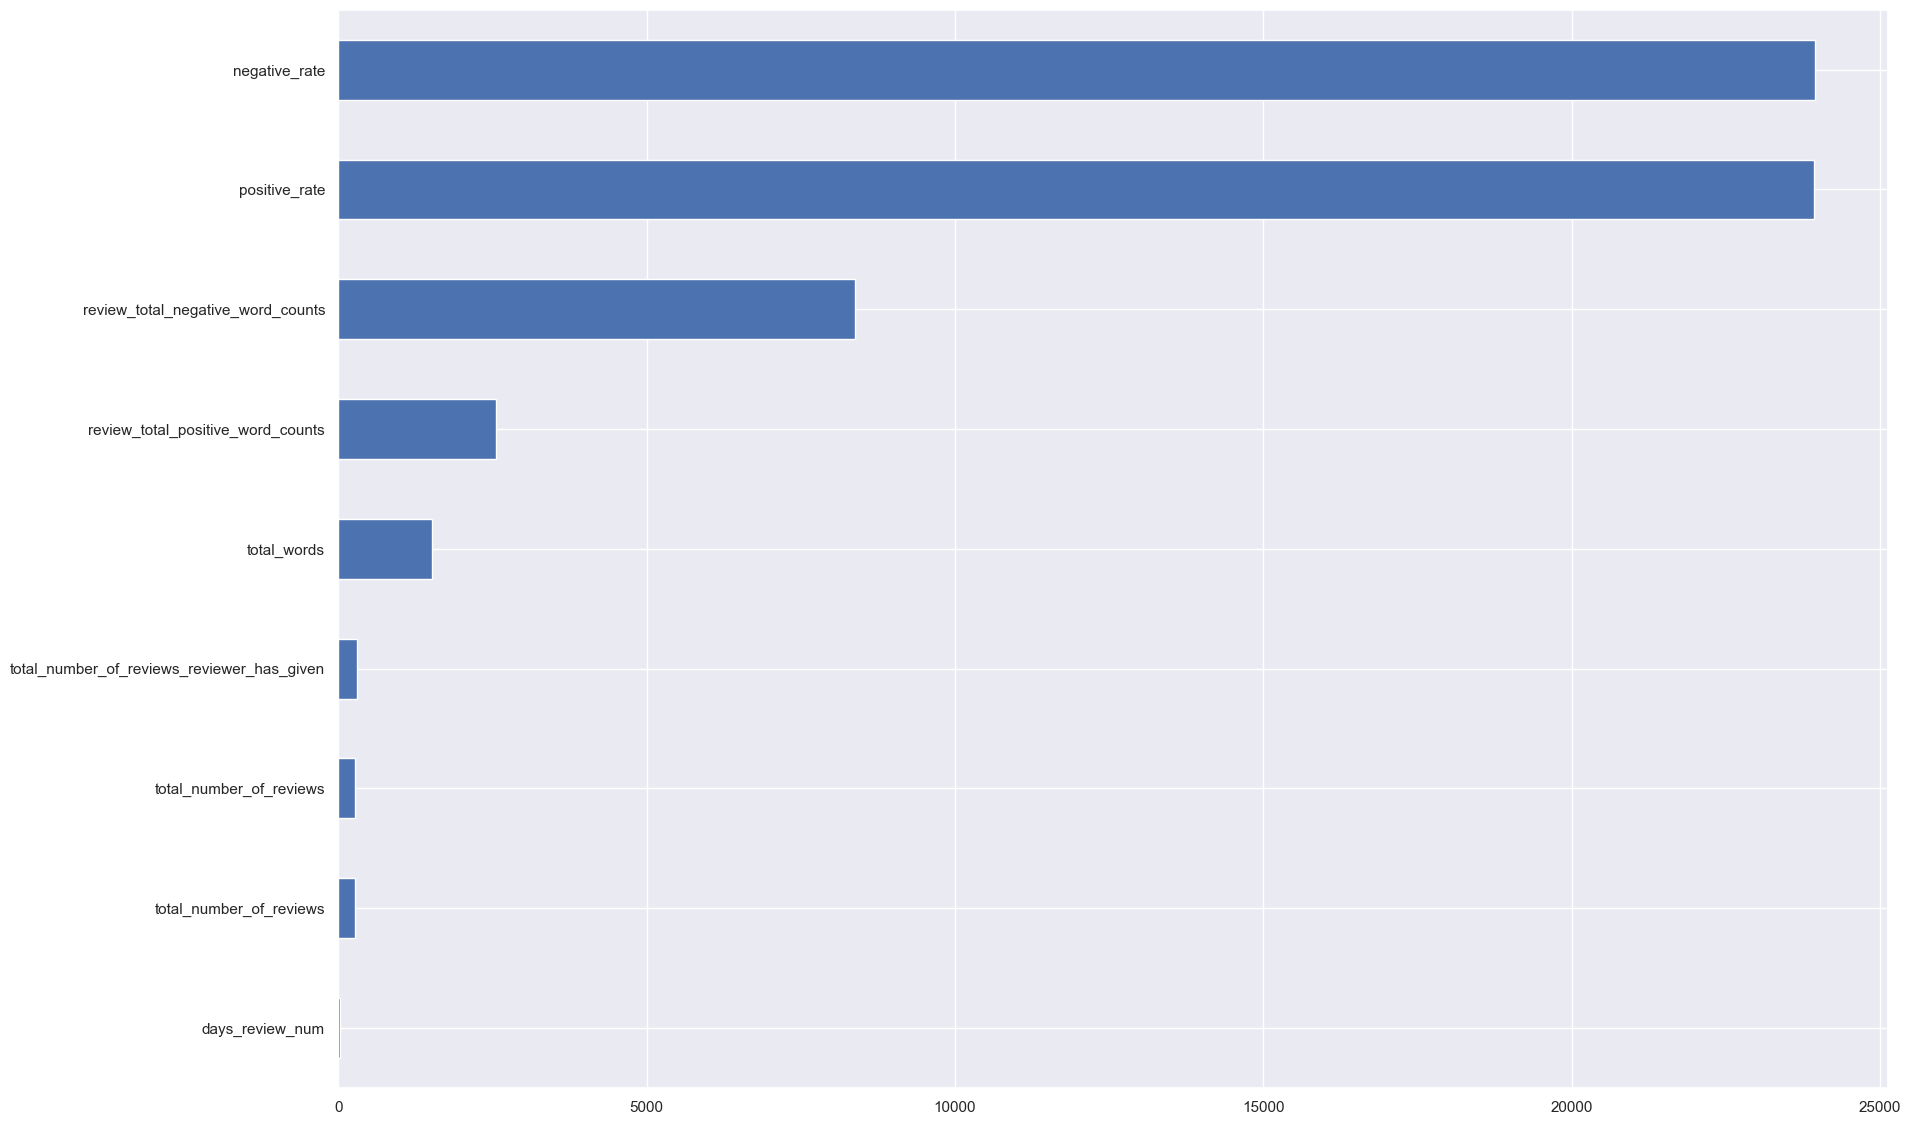

In [142]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### 2.4.1 Удаление признаков, слабо влияющих на целевую переменную

In [143]:
final_features = ['negative_staff', 'negative_clean', 'negative_old', 'positive_staff',
                   'negative_bed', 'negative_bath', 'negative_price', 'positive_room',
                   'negative_meal', 'lng', # категориальные признаки значение более 5000, которые оставляем
                  'positive_rate', 'review_total_negative_word_counts', # и непрерывные
                  'trip_purpose_2', 'reviewer_nat_group_2', 'positive_breakfast', 'positive_bed', 'reviewer_nat_group_3', 'negative_wifi', 'who_travels_3', 'average_score'
                 ]

features_to_drop = list(set(X.columns) - set(final_features)) # признаки, подлежащие удалению

X = X.drop(features_to_drop, axis=1)
X

,average_score,review_total_negative_word_counts,lng,positive_rate,positive_bed,positive_staff,positive_breakfast,positive_room,negative_meal,negative_bed,negative_bath,negative_wifi,negative_staff,negative_price,negative_old,negative_clean,trip_purpose_2,who_travels_3,reviewer_nat_group_2,reviewer_nat_group_3
0,8,3,0,57.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,3,0,40.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,8,6,2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7,0,2,100.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,8,4,4,83.0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9,0,0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
386799,8,0,16,100.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
386800,6,12,0,43.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
386801,8,0,0,100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# 3. Обучение модели

In [144]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [145]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 63), (386803, 63), (386803, 20), (309442, 20), (77361, 20))

In [146]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [147]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [148]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


In [149]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 1.0658523603018384
MAPE: 0.1632948977565163


<AxesSubplot: >

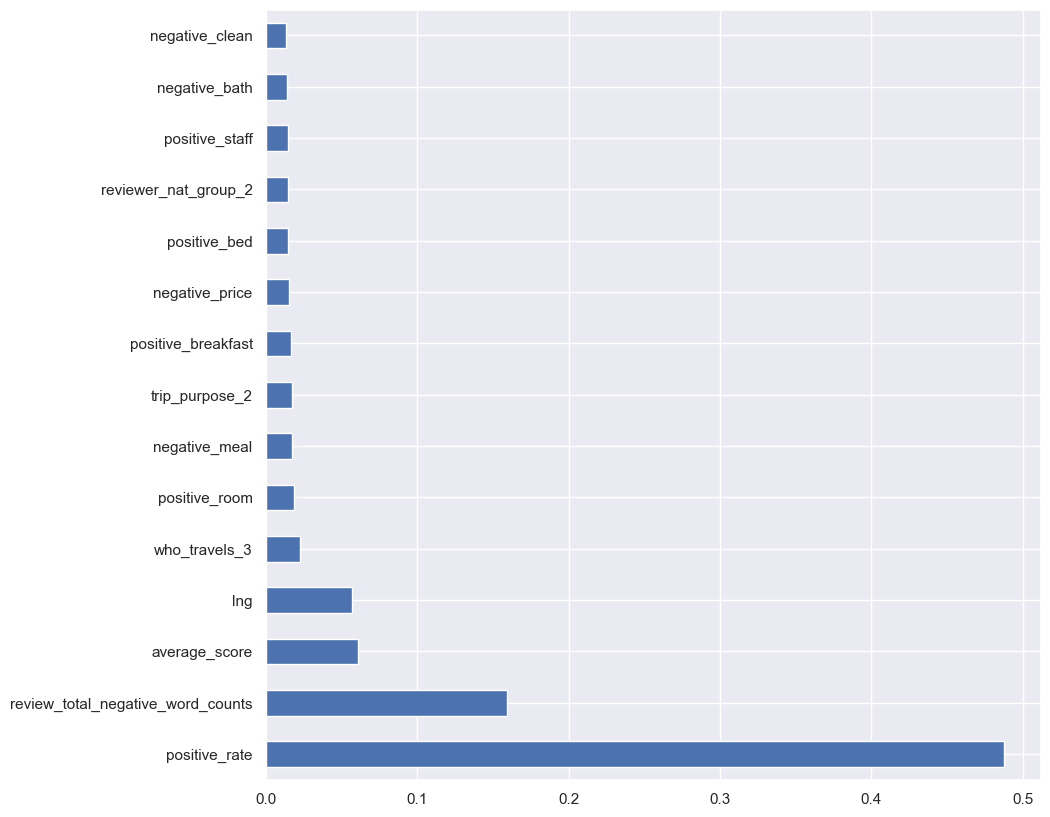

In [150]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [151]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,days_review_num,total_words,...,review_weekday_7,review_season_1,review_season_2,review_season_3,review_season_4,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4
389822,9.1,40,666,89,2,0.0,48.871989,2.349291,338,129,...,0,0,0,0,1,0,0,0,0,1
448391,7.9,7,4065,0,1,0.0,51.516288,-0.172108,91,7,...,0,0,0,1,0,0,0,0,0,1
399845,8.4,37,2405,56,6,0.0,51.510036,-0.190657,471,93,...,0,0,0,1,0,0,0,0,0,1
444163,9.0,15,1209,11,4,0.0,51.493109,-0.190208,597,26,...,0,1,0,0,0,0,0,0,0,1
460698,7.7,85,1238,51,2,0.0,48.210736,16.382147,396,136,...,1,0,0,0,1,0,0,0,0,1
496371,7.5,0,6977,14,1,0.0,51.519569,-0.170521,371,14,...,0,0,0,0,1,0,1,1,1,1
501314,8.1,5,1284,3,8,0.0,48.182516,16.332243,387,8,...,0,0,0,0,1,0,0,0,0,1
425473,7.7,69,3097,58,1,0.0,41.377798,2.113597,32,127,...,1,0,0,0,1,0,0,0,0,1
434514,9.2,5,1010,19,18,0.0,41.393017,2.164615,15,24,...,0,0,0,0,1,0,0,0,0,1
469898,7.4,18,1328,17,8,0.0,51.514958,-0.082387,688,35,...,0,0,1,0,0,0,0,0,0,1


In [152]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [153]:
test_data = test_data.drop(features_to_drop, axis = 1)

In [154]:
test_data

,average_score,review_total_negative_word_counts,lng,positive_rate,positive_bed,positive_staff,positive_breakfast,positive_room,negative_meal,negative_bed,negative_bath,negative_wifi,negative_staff,negative_price,negative_old,negative_clean,trip_purpose_2,who_travels_3,reviewer_nat_group_2,reviewer_nat_group_3
386803,8.1,52,9.171102,54.0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0
386804,8.6,10,4.834443,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
386805,8.3,3,2.161520,62.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
386806,9.1,0,9.196298,100.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
386807,9.1,0,4.888644,100.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,8.1,0,9.221836,100.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
515734,7.8,0,2.178663,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
515735,8.0,31,16.366915,43.0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0
515736,9.0,0,9.207380,100.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [155]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [156]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished


In [157]:
predict_submission

array([8.45      , 9.30629762, 8.44401871, ..., 8.34      , 9.32975232,
       9.09863099])

In [158]:
list(sample_submission)

['reviewer_score', 'id']

In [159]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.450000,488440
1,9.306298,274649
2,8.444019,374688
3,9.633952,404352
4,9.656016,451596
5,8.860000,302161
6,7.140000,317079
7,7.160000,13963
8,9.414964,159785
9,7.195000,195089
